Crypto Momentum Trading
=======================

Inspiration: Huang et.al: Cryptocurrency Volume-Weighted Time Series Momentum
Data: Polarity Digital

**Notes**

* short term reversal (buying the worst 1d momentum works), fading the best also works but is worse

**Todo**

* overall correlation pre, past 2019
* correlation of momentum and return in different market regimes (above, below sma)

Data Preparation
----------------

In [84]:
# prepare data and compute metrics

import duckdb
from glob import glob
import re
from os.path import basename
import polars as pl

con = duckdb.connect(database=':memory:')

stables = set(['dai','bsc-usd','busd','eurc','c1usd','susds','usd1','bfusd','fdusd','pyusd','rlusd','steakusdc','syrupusdc',
           'syrupusdt','tusd','usd0','usdai','usdb','usdc.e','usdc','usdd','usde','usdf',
           'usdg','usds','usdt','usdt0','usdtb','usdy'])
lags = 60

con.execute('''
    create or replace table coins as
    select distinct on (ts, symbol)
        timestamp as ts,
        regexp_extract(filename, 'pd-data/(.+)\\.parquet', 1) as symbol,
        price as close,
        -- volume in USD
        total_volume as volume
    from read_parquet('pd-data/*.parquet', filename=true)
    where symbol not in ?
      and price is not null
      and total_volume > 0
    order by ts desc
''', [tuple(stables)])

con.sql('''
    create index ts_coins on coins(ts);
    create index sym_coins on coins(symbol);
    create unique index sym_ts_coins on coins(symbol, ts);
''')

con.execute('''
    create or replace table open as
    select
        c.ts,
        c.symbol,
        c.close,
        -- crypto trades 24/7 yesterday's close = today's open
        cc.close as open,
        c.volume
    from coins c
    asof join coins cc
        on c.symbol = cc.symbol
        and cc.ts < c.ts
    where c.ts - cc.ts <= interval '25 hour';
    
    create index ts_open on open(ts);
    create index sym_open on open(symbol);
    create unique index sym_ts_open on open(symbol, ts);
''')

con.execute('''
    create or replace table momentum as 
    with params as (
        select
            unnest([1,2,3,4,5,10,15,20,30,60]) as lag
    )
    select
        td.ts,
        td.symbol,
        ln(td.close / td.open) as ret,
        p.lag,
        ln(td.open / hori.open) as mom
    from open td
    cross join params p
    asof join open hori
        on td.symbol = hori.symbol
        and hori.ts <= td.ts - (p.lag * interval '1 day')
    where td.close is not null 
      and td.open is not null
      and hori.close is not null
''')#, [lags])

con.sql('''
    create index ts_mom on momentum(ts);
    create index sym_mom on momentum(symbol);
    create unique index sym_ts_lag_mom on momentum(symbol, lag, ts);
''')

con.sql('''
    create or replace table benchmark as
    select
        year(ts) as year,
        sum(ln(close / open)) as ret
    from open
    where symbol = 'btc'
    group by year;
    
    create unique index yr_bench on benchmark(year);
''')

con.sql('''
    create or replace table volume as
    with vol as (
        select
            ts,
            symbol,
            sum(volume) over (partition by ts) as total,
            volume::double / total as rel
        from coins
    )        
    select
        td.ts,
        td.symbol,
        yd.total as sum_yd,
        yd.rel as rel_yd,
        td.rel as rel_td
    from vol td
    asof join vol yd
        on yd.symbol = td.symbol
        and yd.ts <= td.ts - interval '1 day'
    where td.ts - yd.ts <= interval '25 hours';
    
    create unique index rv_ts_sym on volume(ts, symbol);
    create index rv_sym on volume(symbol);
''')

con.sql('''
create or replace table sma as
select
    c.ts,
    c.symbol,
    avg(volume) over w20 as vol20,
    avg(volume) over w50 as vol50,
    avg(volume) over w100 as vol100,
    avg(volume) over w200 as vol200,

    avg(rel_td) over w20 as relvol20,
    avg(rel_td) over w50 as relvol50,
    avg(rel_td) over w100 as relvol100,
    avg(rel_td) over w200 as relvol200,

    avg(close) over w20 as close20,
    avg(close) over w50 as close50,
    avg(close) over w100 as close100,
    avg(close) over w200 as close200
from coins c
join volume on volume.ts = c.ts and volume.symbol = c.symbol
window
    w20 as (partition by c.symbol order by c.ts rows between 20 preceding and 1 preceding),
    w50 as (partition by c.symbol order by c.ts rows between 50 preceding and 1 preceding),
    w100 as (partition by c.symbol order by c.ts rows between 100 preceding and 1 preceding),
    w200 as (partition by c.symbol order by c.ts rows between 200 preceding and 1 preceding)
order by c.ts
''')

emas = con.sql("""
    select
        c.ts,
        c.symbol,
        c.close,
        v.rel_td,
        c.volume
    from coins c
    join volume v on v.ts = c.ts and v.symbol = c.symbol
    order by c.symbol, c.ts
""").pl().with_columns([
    pl.col("close")
        .ewm_mean(span=5, adjust=False)
        .shift(1)
        .over("symbol")
        .alias("close_ema5"),
    pl.col("close")
        .ewm_mean(span=60, adjust=False)
        .shift(1)
        .over("symbol")
        .alias("close_ema60"),

    pl.col("volume")
        .ewm_mean(span=5, adjust=False)
        .shift(1)
        .over("symbol")
        .alias("vol_ema5"),
    pl.col("volume")
        .ewm_mean(span=60, adjust=False)
        .shift(1)
        .over("symbol")
        .alias("vol_ema60"),

    pl.col("rel_td")
        .ewm_mean(span=5, adjust=False)
        .shift(1)
        .over("symbol")
        .alias("relvol_ema5"),
    pl.col("rel_td")
        .ewm_mean(span=60, adjust=False)
        .shift(1)
        .over("symbol")
        .alias("relvol_ema60"),
])
con.execute("""
    create or replace table ema as select * from emas
""")

del emas

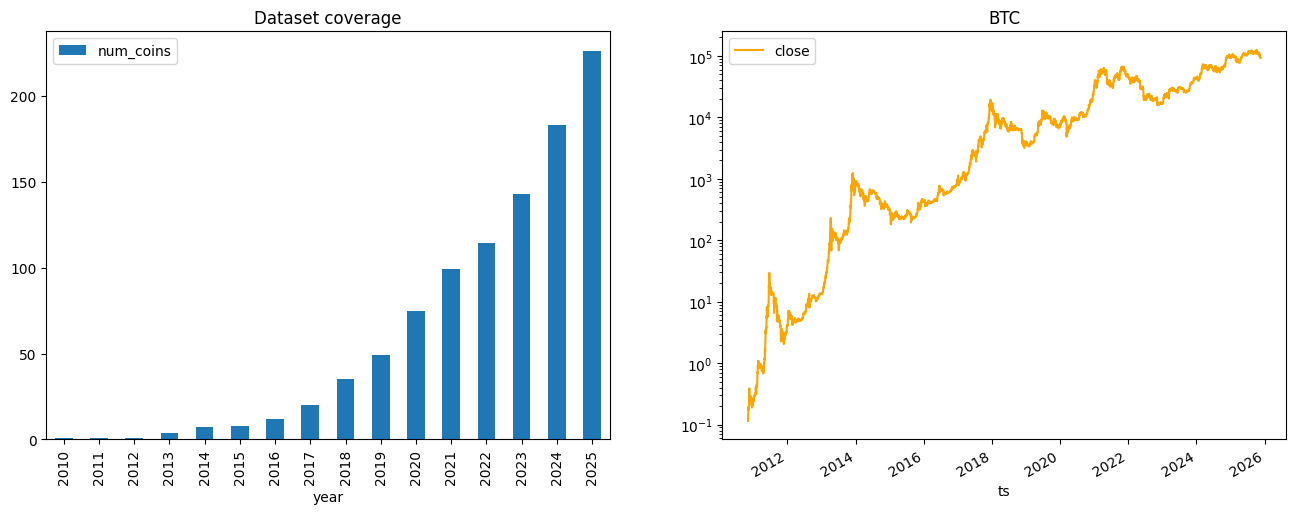

In [90]:
# coin data coverage

import matplotlib.pyplot as plt

df1 = con.sql('''
    select 
        year(ts) as year,
        count(distinct symbol) as num_coins
    from coins
    group by year
    order by year
''').df()

df2 = con.sql('''
    select
        ts, close
    from coins
    where symbol = 'btc'
    order by ts
''').df()

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))

df1.plot(ax=ax1, x='year', y='num_coins', kind='bar', title='Dataset coverage')
df2.plot(ax=ax2, x='ts', y='close', logy=True, color='orange', title='BTC')

plt.show()

Correlation With Past Momentum
------------------------------

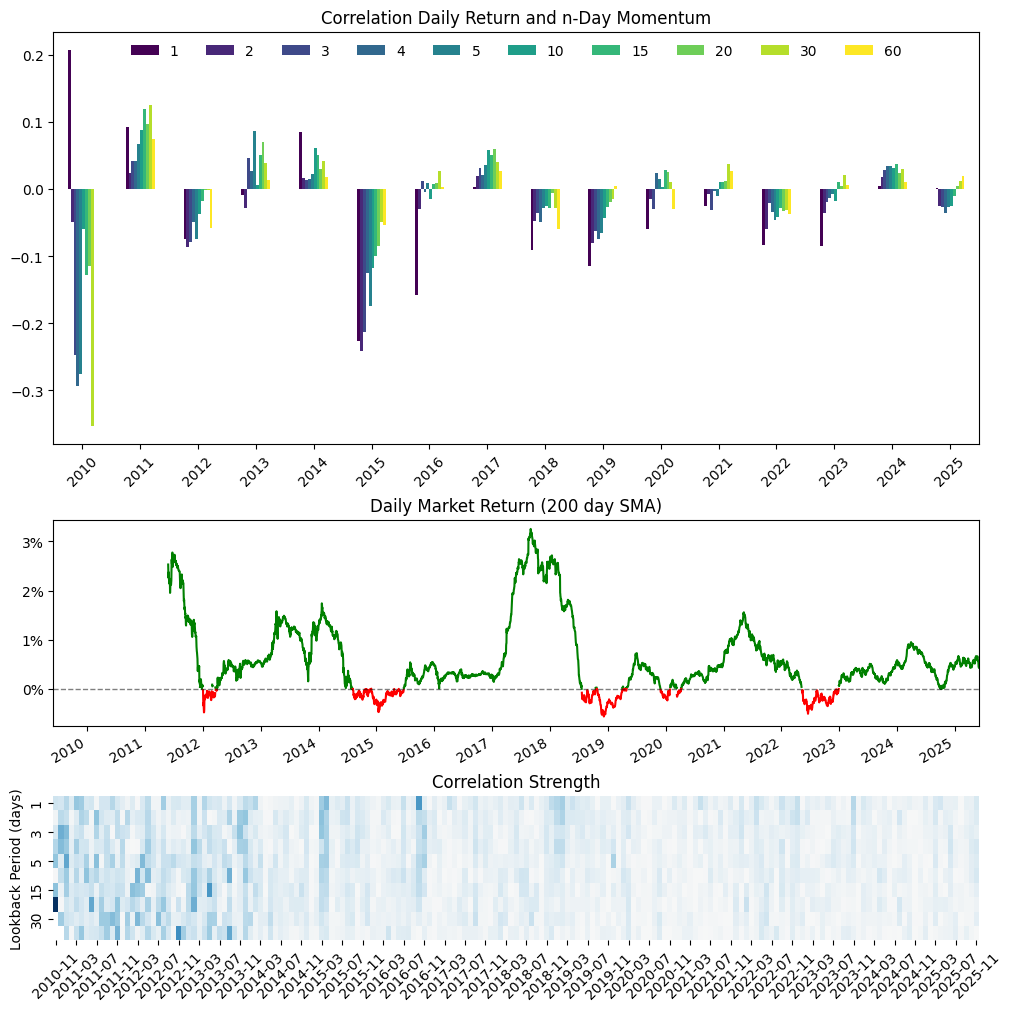

In [307]:
# correlation return and momentum with various lags

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

import seaborn as sns

df_yr = con.sql('''
    select
        year(ts) as year,
        lag,
        corr(mom, ret) as correlation
    from momentum
    where lag in (1,2,3,4,5,10,15,20,30,60)
    group by 1, 2
    order by 1, 2
''').df().pivot(index='year', columns='lag', values='correlation')

df_mo = con.sql('''
    select
        strftime(ts, '%Y-%m') as year_month,
        lag,
        abs(corr(mom, ret)) as correlation
    from momentum
    where lag in (1,2,3,4,5,10,15,20,30,60)
    group by 1, 2
    order by 1, 2
''').df().pivot(index='lag', columns='year_month', values='correlation')

df_ret = con.sql('''
    select
        m.ts,
        exp(sum(v.rel_td * m.ret) / sum(v.rel_td)) - 1 as ret
    from momentum m
    join volume v 
      on v.ts = m.ts and v.symbol = m.symbol
    where m.lag = 1
    group by m.ts
    order by m.ts
''').df()
df_ret['sma'] = df_ret.ret.rolling(window=200).mean()

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1, .7]},layout='constrained')

df_yr.plot(
    ax=ax1,
    kind='bar',
    title='Correlation Daily Return and n-Day Momentum',
    colormap='viridis')
ax1.set_xlabel('')
ax1.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1),
    ncol=10,
    frameon=False
)
ax1.tick_params(axis='x', rotation=45)

df_ret.mask(df_ret.sma <= 0).plot(ax=ax2, x='ts', y='sma', color='green', legend=False)
df_ret.mask(df_ret.sma > 0).plot(ax=ax2, x='ts', y='sma', color='red', legend=False)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax2.set_title('Daily Market Return (200 day SMA)')
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_major_locator(mdates.YearLocator())
start_date = pd.Timestamp('2009-06-01')
end_date = pd.Timestamp('2025-06-01')

ax2.set_xlim(start_date, end_date)
sns.heatmap(
    df_mo,
    ax=ax3,
    annot=False,
    cmap='RdBu',
    center=0,
    cbar=False)
ax3.set_title('Correlation Strength')
ax3.set_ylabel('Lookback Period (days)')
ax3.set_xlabel('')
ax3.tick_params(axis='x', rotation=45)

plt.show()

<Axes: xlabel='year'>

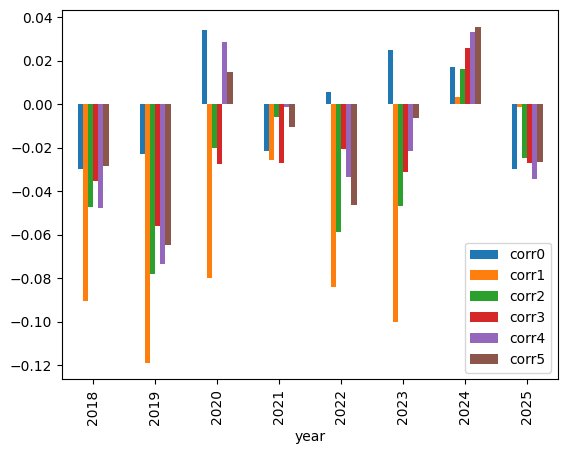

In [73]:
con.sql('''
with signal as (
    select
        ts,
        symbol,
        case
            when lag(close_ema5) over w <= lag(close_ema60) over w and close_ema5 > close_ema60
            then 1
            when lag(close_ema5) over w  >= lag(close_ema60) over w and close_ema5 < close_ema60
            then -1
            else null
        end as value
    from ema
    window w as (partition by symbol order by ts)
), regime as (
    select
        ts,
        symbol,
        last_value(value ignore nulls) over w as value
    from signal
    window w as (partition by symbol order by ts rows between 5 preceding and 1 preceding)
)
select
    year(m1.ts) as year,
    corr(r.value, m1.ret) as corr0,
    corr(m1.mom, m1.ret) as corr1,
    corr(m2.mom, m2.ret) as corr2,
    corr(m3.mom, m3.ret) as corr3,
    corr(m4.mom, m4.ret) as corr4,
    corr(m5.mom, m5.ret) as corr5
from momentum m1
join momentum m2
  on m1.ts = m2.ts and m1.symbol = m2.symbol
join momentum m3
  on m1.ts = m3.ts and m1.symbol = m3.symbol
join momentum m4
  on m1.ts = m4.ts and m1.symbol = m4.symbol
join momentum m5
  on m1.ts = m5.ts and m1.symbol = m5.symbol
join regime r
  on m1.ts = r.ts and m1.symbol = r.symbol
join sma s
  on s.ts = m1.ts and s.symbol = m1.symbol
where s.relvol50 > 0.00
  and m1.lag = 1 and m2.lag = 2 and m3.lag = 3 and m4.lag = 4 and m5.lag = 5
  and year(m1.ts) >= 2018
group by year
order by year
''').df().plot(kind='bar', x='year', y=['corr0','corr1','corr2','corr3','corr4','corr5'])

<Axes: xlabel='year'>

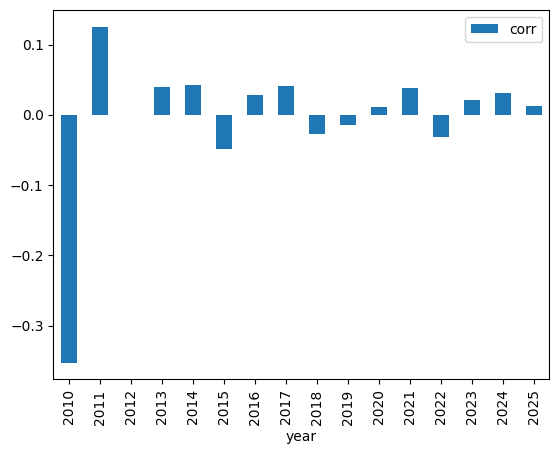

In [83]:
con.sql('''
select
    year(ts) as year,
    corr(ret, mom) as corr
from momentum
where lag = 30
group by year(ts)
order by year
''').df().plot(kind='bar', x='year', y='corr')

In [80]:
# vol weight allocation
# add vol z score
# add mcap
# add auto correlation
# encode crossing as triangle wave 0.01 0.1 1 (bullish cross) 0.1 0.01 and negative on bearish
# try linear models
# different up down patterns (up up down) for example 
# sma/ema slope
# above ma and rising, vol above 20 sma and rising
 
duckdb.sql('''
create or replace table returns as
select
    year(ts) as year,
    symbol,
    lag,
    sum(ret) as ret
from momentum
where mom > 0
group by year, symbol, lag
''')

duckdb.sql('''
create or replace table cross_alpha as
select
    r.year,
    r.lag,
    avg(r.ret - b.ret) as ret
from returns r
join benchmark b
  on b.year = r.year
group by r.year, r.lag
''')